In [87]:
import warnings
warnings.simplefilter("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [88]:
test=pd.read_csv("C:/Users/chenl/Data Science prep/data/test_results - Pricing_Test.csv", parse_dates=["timestamp"])
user=pd.read_csv("C:/Users/chenl/Data Science prep/data/user_table - Pricing_Test.csv")
test["timestamp"] = pd.to_datetime(test["timestamp"], errors="coerce") # this would result in 5k null value, likely some inconsistency in format, unknown yet

In [89]:
test.info() # 5000 Na from timestamp column due to unknown reason, ignore fore now as not impact the core analysis purposes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           316800 non-null  int64         
 1   timestamp         311620 non-null  datetime64[ns]
 2   source            316800 non-null  object        
 3   device            316800 non-null  object        
 4   operative_system  316800 non-null  object        
 5   test              316800 non-null  int64         
 6   price             316800 non-null  int64         
 7   converted         316800 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 19.3+ MB


In [90]:
user.info()
# no null value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275616 entries, 0 to 275615
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  275616 non-null  int64  
 1   city     275616 non-null  object 
 2   country  275616 non-null  object 
 3   lat      275616 non-null  float64
 4   long     275616 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 10.5+ MB


In [91]:
data=pd.merge(test,user,how="left",on="user_id")
data.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


In [92]:
data.groupby(["test","price"]).count()
# some error in the data, control group with 59 price, and test group with 39 as price

user_id  timestamp  source  device  operative_system  converted  \
test price                                                                    
0    39      202517     199151  202517  202517            202517     202517   
     59         210        209     210     210               210        210   
1    39         155        153     155     155               155        155   
     59      113918     112107  113918  113918            113918     113918   

              city  country     lat    long  
test price                                   
0    39     176241   176241  176241  176241  
     59        187      187     187     187  
1    39        135      135     135     135  
     59      99053    99053   99053   99053

In [93]:
# delete those, minimum impact
data=data[((data["test"]==0) & (data["price"]==39)) | ((data["test"]==1) & (data["price"]==59))]
data.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


In [94]:
data.isnull().sum()

user_id                 0
timestamp            5177
source                  0
device                  0
operative_system        0
test                    0
price                   0
converted               0
city                41141
country             41141
lat                 41141
long                41141
dtype: int64

# analysis: check the randomness

In [95]:
# devide into test group and control
control= data[data["test"]==0]
new= data[data["test"]==1]

In [96]:

group_count=data["test"].value_counts(normalize=True)
group_count
# close enough in distribution

test
0    0.639996
1    0.360004
Name: proportion, dtype: float64

In [97]:
#by source
source_control= control["source"].value_counts(normalize=True)
source_test=    new["source"].value_counts(normalize=True)
source_counts=pd.DataFrame({
    "control":source_control,
    "test":source_test
})
source_counts
# seems random enough

,control,test
source,,
ads-bing,0.072014,0.072394
ads-google,0.186873,0.188706
ads-yahoo,0.023761,0.024219
ads_facebook,0.168253,0.169253
ads_other,0.095083,0.092786
direct_traffic,0.191154,0.189259
friend_referral,0.064790,0.066337
seo-bing,0.006562,0.007154
seo-google,0.074502,0.070753


In [98]:
#by device
device_control= control["device"].value_counts(normalize=True)
device_test=    new["device"].value_counts(normalize=True)
device_counts=pd.DataFrame({
    "control":device_control,
    "test":device_test
})
device_counts
# seems random enough

,control,test
device,,
mobile,0.594365,0.578469
web,0.405635,0.421531


In [99]:
#by system
system_control= control["operative_system"].value_counts(normalize=True)
system_test=    new["operative_system"].value_counts(normalize=True)
system_counts=pd.DataFrame({
    "control":system_control,
    "test":system_test
})
system_counts
# prettu fair distributed

,control,test
operative_system,,
windows,0.313638,0.327718
iOS,0.305125,0.294598
android,0.237891,0.234318
mac,0.080709,0.076459
other,0.051754,0.050001
linux,0.010883,0.016907


# Q1
Should the company sell its software for $39 or $59?

      converted
test           
0      0.019900
1      0.015555
       revenue
test          
0     0.776083
1     0.917748


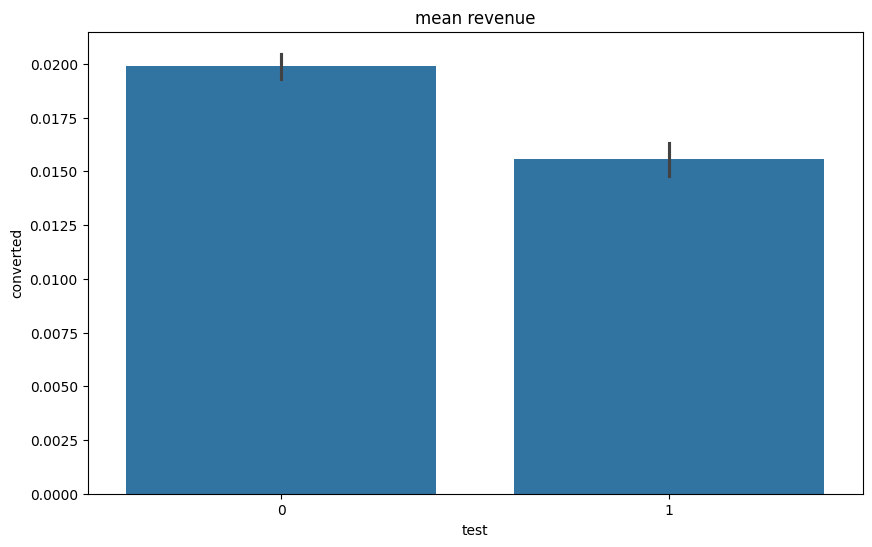

In [100]:
# convertion rate
print(data[['test', 'converted']].groupby("test").mean())
# average revenue ---- mean price for entire group 
data["revenue"]=data["price"]*data["converted"]
print(data[['test', 'revenue']].groupby("test").mean())
plt.figure(figsize=(10,6))
sns.barplot(data=data, x='test', y='converted')
plt.title('mean revenue')
plt.show()

-5.715224666463108 1.0972577312420781e-08


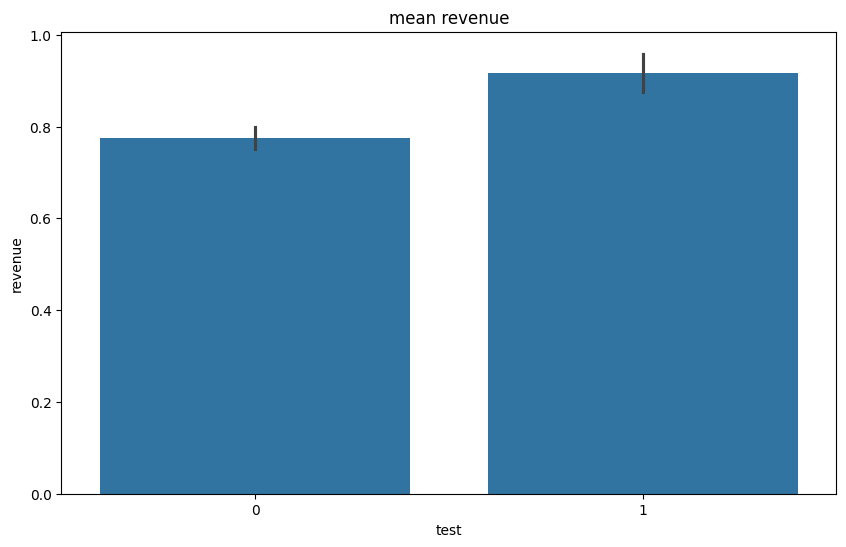

In [101]:
# t test
groupa=data[data["test"]==0]["revenue"]
groupb=data[data["test"]==1]["revenue"]
t_stat, p_value=ttest_ind(groupa,groupb,equal_var=False) # default assume 2 groups has same variances, if not set it to False
print(t_stat, p_value)
# graph
plt.figure(figsize=(10,6))
sns.barplot(data=data, x='test', y='revenue')
plt.title('mean revenue')
plt.show()

1. conversion rate is significant higher for 39 price group
2. but the average revenue, is higher for 59, lead to higher overall revenue in broad level

# Q2
actionable insights that might increase conversion rate
- converstion rate via few features,
- conversion rate for 1,0 group compare, with bar plot to check the CI

                 converted
source                    
ads-bing          0.012001
ads-google        0.021502
ads-yahoo         0.014793
ads_facebook      0.021198
ads_other         0.014350
direct_traffic    0.012294
friend_referral   0.038688
seo-bing          0.023787
seo-google        0.016978
seo-other         0.015686
seo-yahoo         0.016226
seo_facebook      0.016051


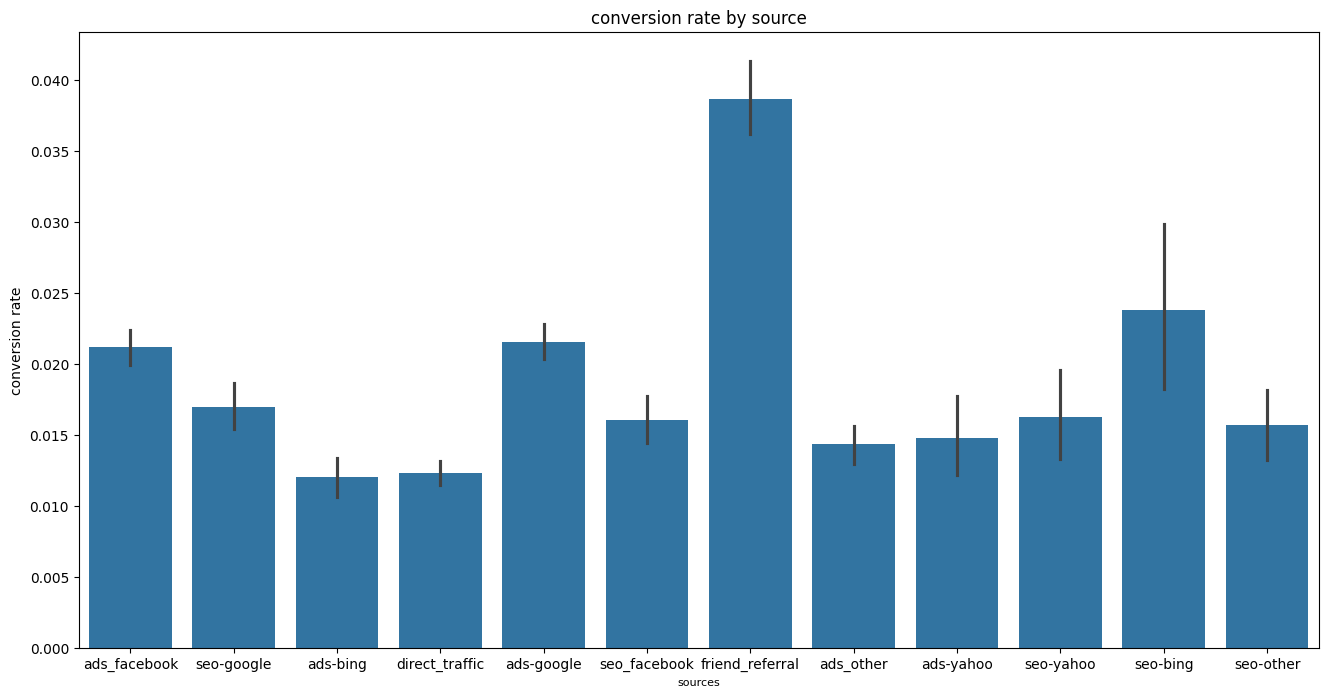

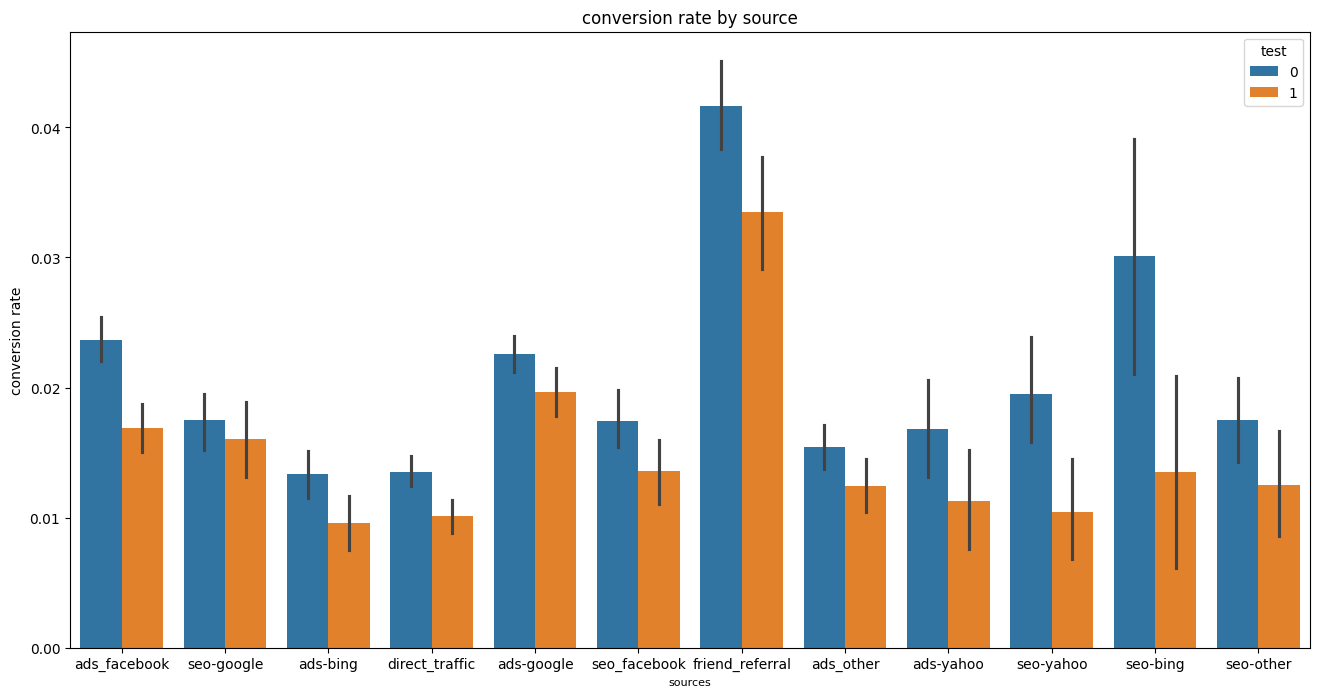

In [102]:
# source
print(data[['source', 'converted']].groupby('source').mean())
# Bar plot
plt.figure(figsize=(16, 8))
sns.barplot(x="source", y="converted", data=data) # ci=95 is defualt
plt.xlabel("sources",fontsize=8)
plt.ylabel("conversion rate")
plt.title("conversion rate by source")
plt.show()
# with test group diff
plt.figure(figsize=(16, 8))
sns.barplot(x="source", y="converted", data=data, hue="test")
plt.xlabel("sources",fontsize=8)
plt.ylabel("conversion rate")
plt.title("conversion rate by source")
plt.show()

        converted
device           
mobile   0.018554
web      0.018023


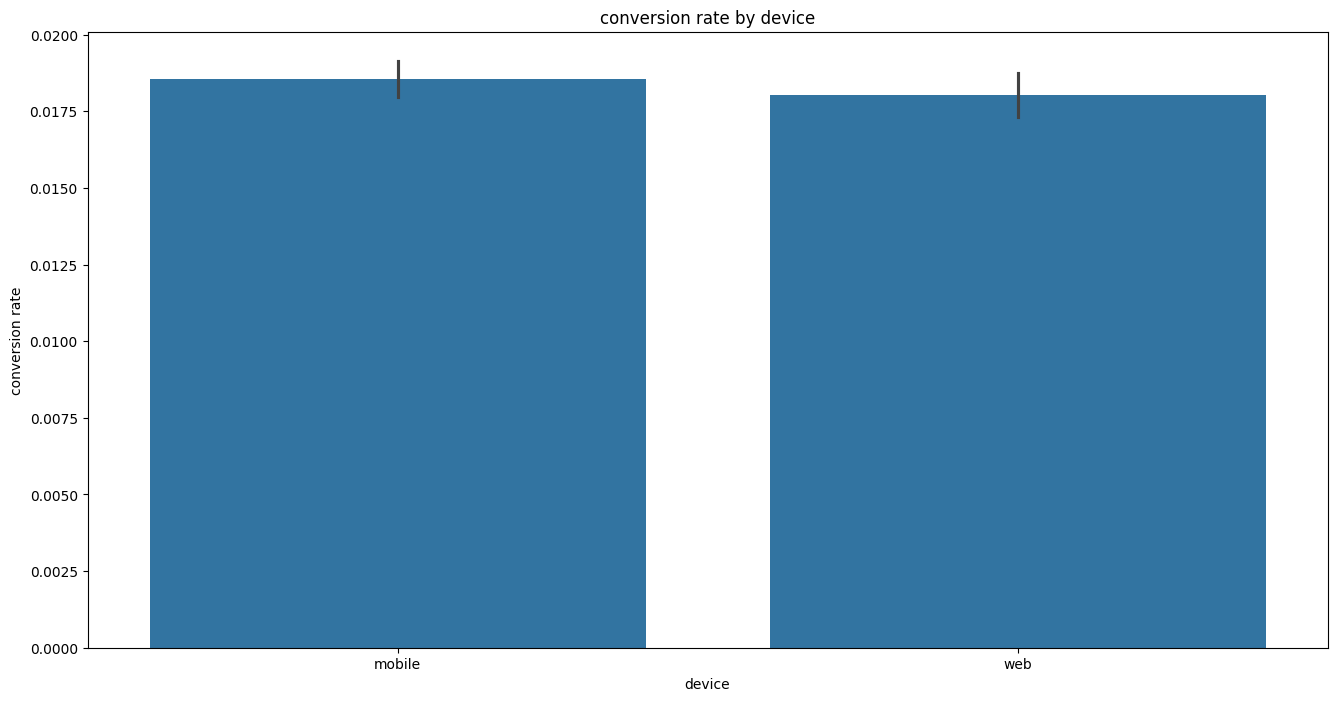

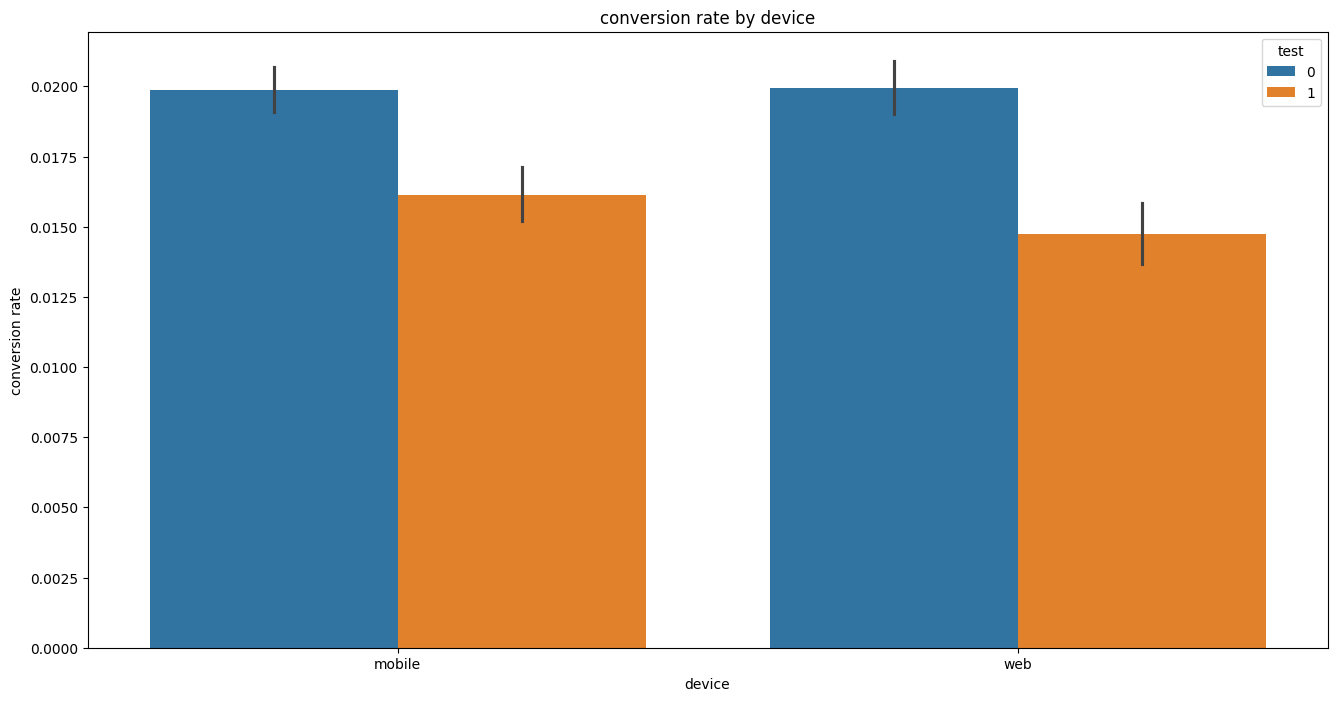

In [103]:
# device
print(data[['device', 'converted']].groupby('device').mean())
# Bar plot
plt.figure(figsize=(16, 8))
sns.barplot(x="device", y="converted", data=data) # ci=95 is defualt
plt.ylabel("conversion rate")
plt.title("conversion rate by device")
plt.show()
# with test group diff
plt.figure(figsize=(16, 8))
sns.barplot(x="device", y="converted", data=data, hue="test")
plt.ylabel("conversion rate")
plt.title("conversion rate by device")
plt.show()

                  converted
operative_system           
android            0.014919
iOS                0.022328
linux              0.008232
mac                0.023987
other              0.012981
windows            0.016966


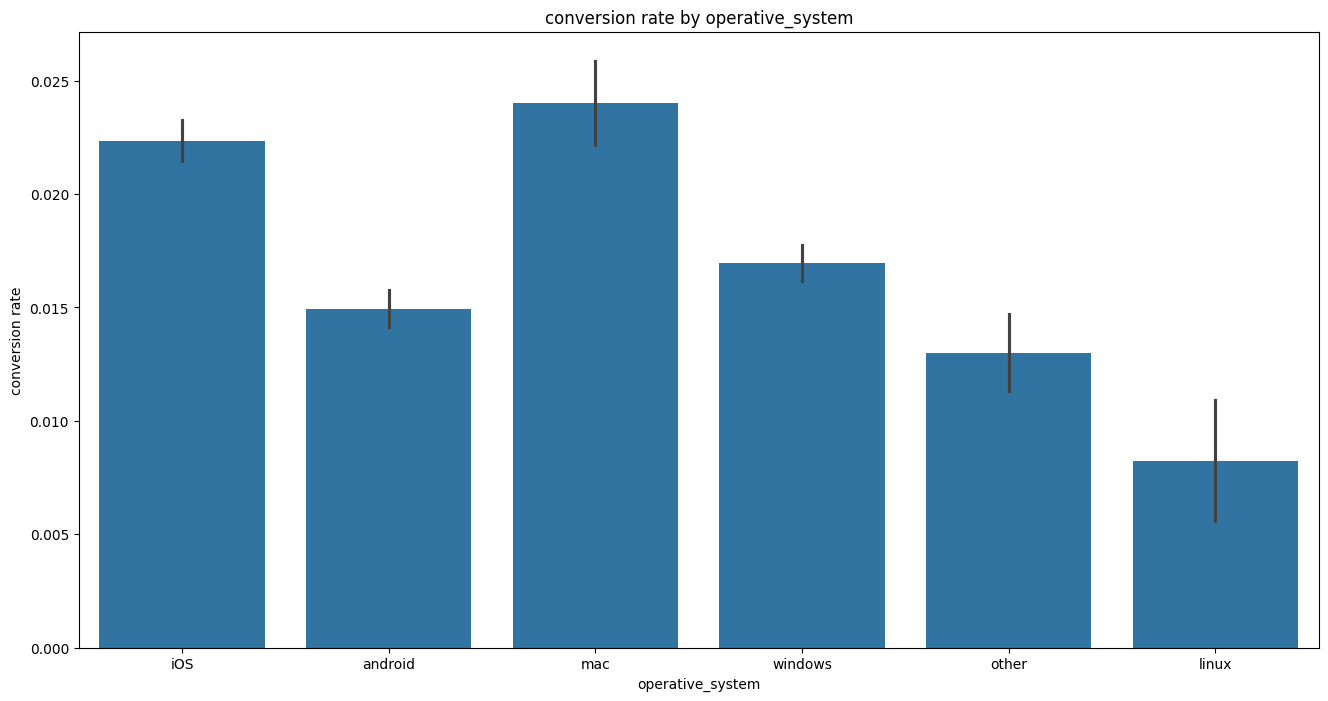

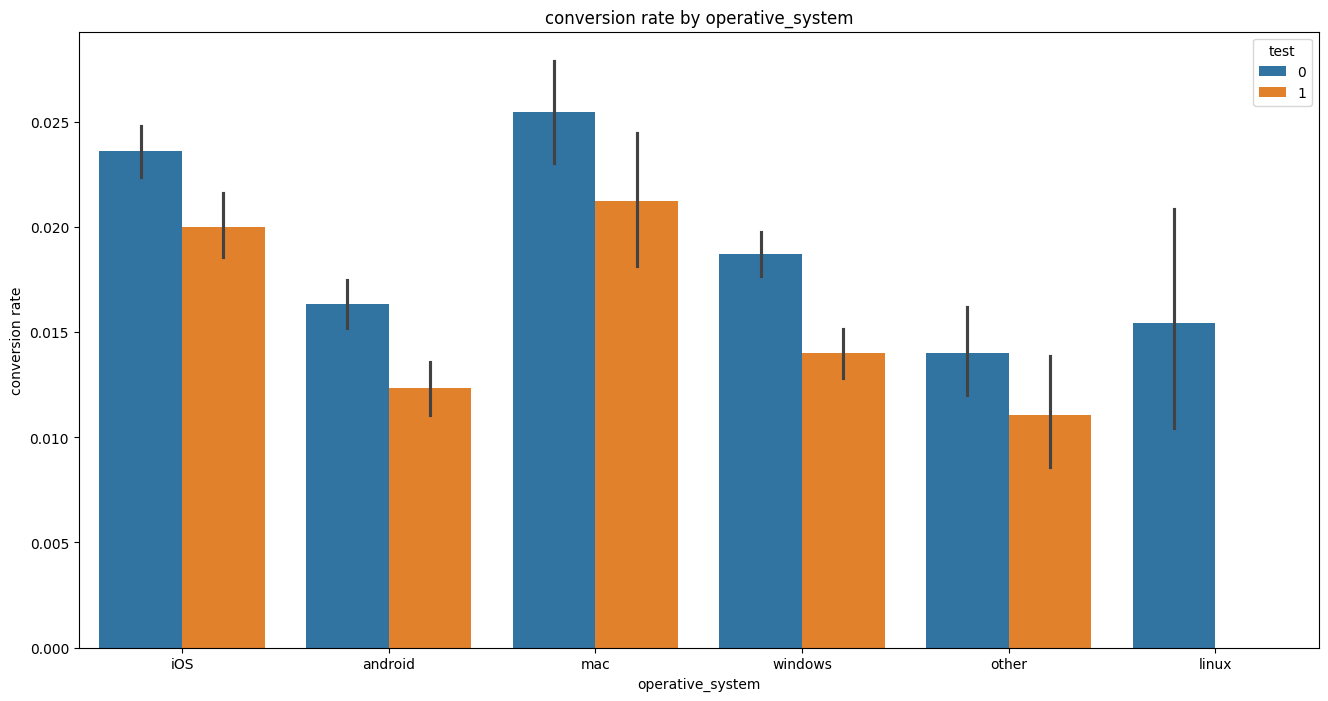

In [104]:
# operative_system
print(data[['operative_system', 'converted']].groupby('operative_system').mean())
# Bar plot
plt.figure(figsize=(16, 8))
sns.barplot(x="operative_system", y="converted", data=data) # ci=95 is defualt
plt.ylabel("conversion rate")
plt.title("conversion rate by operative_system")
plt.show()
# with test group diff
plt.figure(figsize=(16, 8))
sns.barplot(x="operative_system", y="converted", data=data, hue="test")
plt.ylabel("conversion rate")
plt.title("conversion rate by operative_system")
plt.show()

Source: Friend-referral users with highest conversion rate

Device: The influence between devices not significant

Operative System: Mac and ios users with higher conversion rate

# Q3 
After how many days you would have stopped the test? - power analysis

Effect Size (d): The minimum meaningful difference between groups (e.g., in conversion rates or revenue). common - 0.2, 0.5, 0.
- note: use the Calculate Cohen's d = (mu2 - mu1) / std to set up the effect_size parameter

Significance Level (α): The acceptable probability of a Type I error (commonly set at 0.05).

Power (1-β): The probability of detecting a true effect (commonly set at 0.8 or 80%).

Baseline Metric: The existing metric (e.g., conversion rate) for the control group.

In [107]:
from statsmodels.stats.power import TTestIndPower
# calculation of the std for both revenue and conversion
# revenue - 
n1 = len(data[data["test"] == 0])  # Sample size for group 0
n2 = len(data[data["test"] == 1])  # Sample size for group 1

s1 = np.std(data[data["test"] == 0]["revenue"], ddof=1)  # Std dev for group 0
s2 = np.std(data[data["test"] == 1]["revenue"], ddof=1)  # Std dev for group 1

# Pooled standard deviation
pooled_std_revenue = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
print(f"Pooled standard deviation (Revenue): {pooled_std_revenue:.4f}")

# Conversion rates - this is binary std, diff calculation
p1 = data[data["test"] == 0]["converted"].mean()  # Mean conversion rate for group 0
p2 = data[data["test"] == 1]["converted"].mean()  # Mean conversion rate for group 1

# Group sizes
n1 = len(data[data["test"] == 0])  # Size of group 0
n2 = len(data[data["test"] == 1])  # Size of group 1

# Combined conversion rate
p_combined = (p1 * n1 + p2 * n2) / (n1 + n2)

# Combined standard deviation
std_combined_conversion = np.sqrt(p_combined * (1 - p_combined))
print(f"Combined standard deviation (Conversion Rate): {std_combined_conversion:.4f}")



Pooled standard deviation (Revenue): 6.1786
Combined standard deviation (Conversion Rate): 0.1342


In [106]:
effect_size=0.02
alpha=0.005
power=0.90
analysis=TTestIndPower()
required_sample=analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, alternative='larger') # one side test, larger or smaller
required_sample # sample size calculated in the power analysis required for each group
# seems like sample is greater enough in stat base
# if detail is need, use above std from both mean revenue and conversion rate to calculate size needed for both the practice

74398.59873691789